In [1]:
df1 <- read.csv('output/gene/metrics_clinical_plus_genes.csv', sep=',')

head(df1)

experiment,marker,train_auc,valid_auc,train_loss,valid_loss,execution_time,threshold,accuracy,precision,sensitivity,specificity
0,cmmc,0.6797619,0.5120690,0.5522653,0.5637071,71.85949,0.2515360,0.7435897,0.5000000,0.3000000,0.8965517
1,cmmc,0.6576610,0.5607143,0.5357400,0.5656558,92.89044,0.2447377,0.4210526,0.2500000,0.6000000,0.3571429
2,cmmc,0.6262730,0.6250000,0.5439475,0.5635521,76.18885,0.2319463,0.7368421,0.5000000,0.2000000,0.9285714
3,cmmc,0.6417810,0.4857143,0.5368714,0.5882609,74.27151,0.2359264,0.3421053,0.2580645,0.8000000,0.1785714
4,cmmc,0.6215764,0.8428571,0.5479823,0.5207046,74.61579,0.2573695,0.8421053,0.7500000,0.6000000,0.9285714
5,cmmc,0.6985936,0.4603175,0.5246536,0.5478986,80.27367,0.2513442,0.7297297,0.4000000,0.2222222,0.8928571


In [2]:
df2 <- read.csv('output/gene/metrics_clinical_only.csv', sep=',')

head(df2)

experiment,marker,train_auc,valid_auc,train_loss,valid_loss,execution_time,threshold,accuracy,precision,sensitivity,specificity
0,cmmc,0.6251167,0.5120690,0.5454276,0.5735952,21.45124,0.2516665,0.7435897,0.5000000,0.3000000,0.8965517
1,cmmc,0.6421995,0.5428571,0.5366238,0.5665084,22.18100,0.2565433,0.4210526,0.2500000,0.6000000,0.3571429
2,cmmc,0.6238084,0.4500000,0.5436237,0.5653582,22.20129,0.2341443,0.7368421,0.5000000,0.2000000,0.9285714
3,cmmc,0.6488724,0.4696429,0.5326936,0.5898420,23.67005,0.2480619,0.5263158,0.3000000,0.6000000,0.5000000
4,cmmc,0.6125785,0.8428571,0.5482614,0.5214228,21.36289,0.2647128,0.8421053,0.7500000,0.6000000,0.9285714
5,cmmc,0.6491865,0.4742063,0.5359721,0.5576369,22.36222,0.2316897,0.2972973,0.2424242,0.8888889,0.1071429


Loading required package: ggplot2


[1] 0.09427304
[1] 0.04714424
[1] 0.001090645
[1] 0.1883607


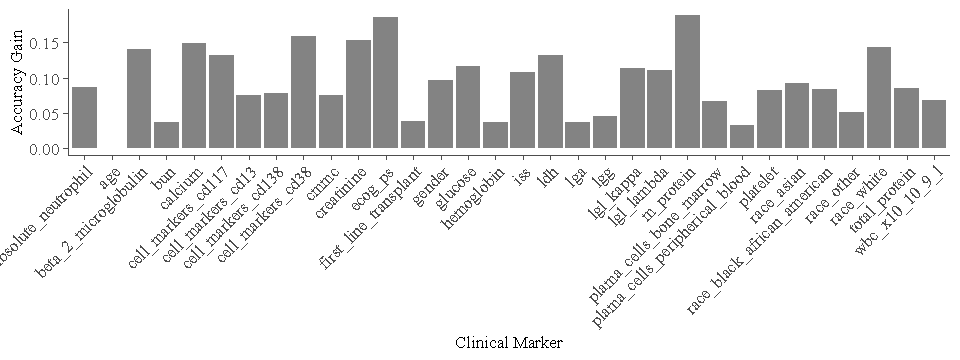

In [3]:
require(ggplot2)

mg <- merge(df1, df2, by=c("marker", "experiment"))

df <- data.frame(marker = mg$marker, 
                 diff = mg$accuracy.x - mg$accuracy.y,
                 fold = mg$experiment)

result <- aggregate(diff ~ marker, data=df, FUN=mean)
colnames(result) <- c("marker", "mean")

tmp <- aggregate(diff ~ marker, data=df, FUN=sd)
colnames(tmp) <- c("marker", "sd")

result <- merge(result, tmp, by="marker")
result$marker = gsub('percent_', '', result$marker)
result <- result[result$mean > 0,]

ticks.line.color='grey30'

p <- ggplot(result) + 
  geom_bar(aes(marker, mean), stat="identity", position="dodge", alpha=.75) + 
  # scale_x_discrete(limits = rev(levels(result$marker))) +
  # scale_y_log10() +
  theme_bw() + 
  theme(panel.border          = element_blank(), 
        panel.grid.major      = element_blank(),
        panel.grid.minor      = element_blank(), 
        axis.line             = element_line(colour=ticks.line.color),
        text                  = element_text(size=10, family="serif"),
        legend.key.size       = unit(10, "pt"),
        legend.position       = 'bottom',
        axis.text.x           = element_text(size=10, angle=45, hjust=1, colour=ticks.line.color),
        axis.text.y           = element_text(size=10, colour=ticks.line.color),
        axis.title.x          = element_text(vjust=1),
        axis.ticks            = element_line(color=ticks.line.color),
        plot.background       = element_rect(fill = "transparent", color=NA), # bg of the plot
        legend.box.background = element_rect(color=NA, fill = "transparent"), # get rid of legend panel bg
        legend.background     = element_rect(colour=NA, size=0),
        legend.key            = element_rect(fill="transparent", colour=NA) # get rid of key legend fill, 
                                                                            #and of the surrounding
        ) +
  xlab("Clinical Marker") + ylab("Accuracy Gain")

print(mean(result$mean))
print(sd(result$mean))
print(min(result$mean))
print(max(result$mean))

ggsave('images/accuracy_gain.pdf', p, units='cm', width=18, height=7)

options(repr.plot.width=8, repr.plot.height=3)

p

[1] 0.1182311
[1] 0.06651135
[1] 0.009599728
[1] 0.2575641


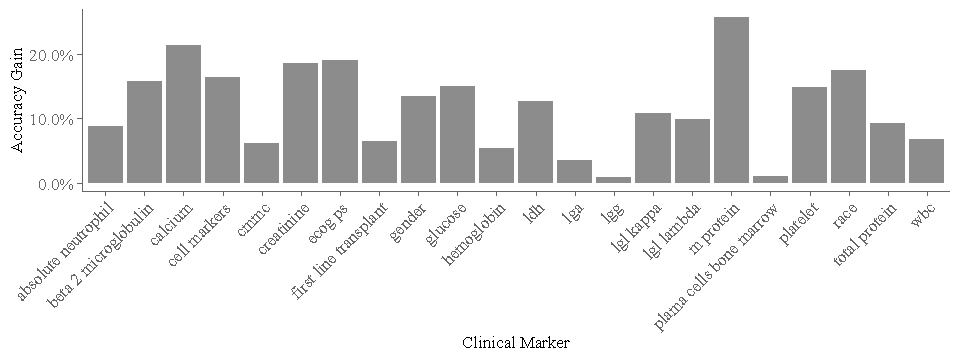

In [4]:
# computing final results
df <- data.frame(feature = mg$marker, 
                 diff = 1 - mg$accuracy.y / mg$accuracy.x,
                 fold = mg$experiment)

result <- aggregate(diff ~ feature, data=df, FUN=mean)
colnames(result) <- c("feature", "mean")

tmp <- aggregate(diff ~ feature, data=df, FUN=sd)
colnames(tmp) <- c("feature", "sd")

result <- merge(result, tmp, by="feature")
result$feature = gsub('percent_', '', result$feature)
result <- result[result$mean > 0,]

# replace "_" by " "
result$feature <- chartr("_", " ", result$feature)

result$feature[grep('cell markers', result$feature, fixed=T)] <- 'cell markers'
result$feature[grep('race', result$feature, fixed=T)] <- 'race'
result$feature[grep('wbc', result$feature, fixed=T)] <- 'wbc'

result <- aggregate(. ~ feature, FUN=mean, data=result)

# creating plot
ticks.line.color='grey40'

p <- ggplot(result) + 
     geom_bar(aes(feature, mean), fill='grey40', stat="identity", position="dodge", alpha=.75) + 
     scale_y_continuous(labels = scales::percent) +
     xlab("Clinical Marker") + 
     ylab("Accuracy Gain") +
     theme_bw() + 
     theme(panel.border          = element_blank(), 
           panel.grid.major      = element_blank(),
           panel.grid.minor      = element_blank(), 
           axis.line             = element_line(colour=ticks.line.color),
           text                  = element_text(size=10, family="serif"),
           legend.key.size       = unit(10, "pt"),
           legend.position       = 'bottom',
           axis.text.x           = element_text(size=10, angle=45, hjust=1, colour=ticks.line.color),
           axis.text.y           = element_text(size=10, colour=ticks.line.color),
           axis.title.x          = element_text(vjust=1),
           axis.ticks            = element_line(color=ticks.line.color),
           plot.background       = element_rect(fill = "transparent", color=NA), # bg of the plot
           legend.box.background = element_rect(color=NA, fill = "transparent"), # get rid of legend panel bg
           legend.background     = element_rect(colour=NA, size=0),
           legend.key            = element_rect(fill="transparent", colour=NA) # get rid of key legend fill, 
                                                                                #and of the surrounding
           )

# showing descriptive statistics
print(mean(result$mean))
print(sd(result$mean))
print(min(result$mean))
print(max(result$mean))

# exporting plot
ggsave('images/accuracy_percentual_gain.pdf', p, units='cm', width=18, height=7)

# showing plot
options(repr.plot.width=8, repr.plot.height=3)

p

In [5]:
t.test(df1$accuracy, df2$accuracy, alternative='greater')


	Welch Two Sample t-test

data:  df1$accuracy and df2$accuracy
t = 7.9466, df = 628.09, p-value = 4.452e-15
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.06689946        Inf
sample estimates:
mean of x mean of y 
0.5267446 0.4423508 
